# Make a big heatmap with accessibilities for top n DARs between clusters
The automated script can be found down below

In [1]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# sample usage
# save_object(company1, 'company1.pkl')

In [2]:
import pyBigWig
import pandas as pd
import numpy as np
from multiprocessing import Process, Value, Array, Pool
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import repeat
import os
import glob
import pickle

# Make a dictionary with filenames for beds and bws

In [3]:
filenames = glob.glob('pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/*.bw')
samples = [item.replace(".bw", "") for item in filenames]
samples = [item.replace("pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/", "") for item in samples]
bw_dict = {samples[i]: filenames[i] for i in range(len(samples))}
bw_dict

{'OPC': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/OPC.bw',
 'MOL': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/MOL.bw',
 'END': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/END.bw',
 'L4IT': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/L4IT.bw',
 'AST': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/AST.bw',
 'CGE_Vip': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/CGE_Vip.bw',
 'UNK': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/UNK.bw',
 'L6b': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/L6b.bw',
 'NP': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_f

In [4]:
filenames = glob.glob('DAR_beds_finalannotation_finetuned_reduced/*_DARS.bed')
samples = [item.replace("_DARS.bed", "") for item in filenames]
samples = [item.replace("DAR_beds_finalannotation_finetuned_reduced/", "") for item in samples]
bed_dict = {samples[i]: filenames[i] for i in range(len(samples))}
bed_dict

{'L6IT_Car3': 'DAR_beds_finalannotation_finetuned_reduced/L6IT_Car3_DARS.bed',
 'PIR': 'DAR_beds_finalannotation_finetuned_reduced/PIR_DARS.bed',
 'OPC': 'DAR_beds_finalannotation_finetuned_reduced/OPC_DARS.bed',
 'MGE_Sst': 'DAR_beds_finalannotation_finetuned_reduced/MGE_Sst_DARS.bed',
 'MGL': 'DAR_beds_finalannotation_finetuned_reduced/MGL_DARS.bed',
 'L5ET': 'DAR_beds_finalannotation_finetuned_reduced/L5ET_DARS.bed',
 'L4IT': 'DAR_beds_finalannotation_finetuned_reduced/L4IT_DARS.bed',
 'L2-3': 'DAR_beds_finalannotation_finetuned_reduced/L2-3_DARS.bed',
 'END': 'DAR_beds_finalannotation_finetuned_reduced/END_DARS.bed',
 'MGE_Pvalb': 'DAR_beds_finalannotation_finetuned_reduced/MGE_Pvalb_DARS.bed',
 'AST': 'DAR_beds_finalannotation_finetuned_reduced/AST_DARS.bed',
 'CGE_Lamp5': 'DAR_beds_finalannotation_finetuned_reduced/CGE_Lamp5_DARS.bed',
 'L6CT': 'DAR_beds_finalannotation_finetuned_reduced/L6CT_DARS.bed',
 'NP': 'DAR_beds_finalannotation_finetuned_reduced/NP_DARS.bed',
 'L5-6IT': '

fix the file names so that the names here match.

In [5]:
sorted(list(bw_dict.keys()))==sorted(list(bed_dict.keys()))

True

# Make dictionary of coverage matrices for the sample's dar bed and all bigwigs
The code below explains step-by-step what my automated script (further down below) does.

In [6]:
interval_downstream = 1000
interval_upstream = 1000

In [7]:
sample = 'AST'

In [8]:
df_bed = pd.read_csv(bed_dict[sample], sep='\t', header=None)
df_bed.columns = ['chr', 'start', 'stop', 'name', 'score']
df_bed.set_index('name', inplace=True)
df_bed.index.name = None

### First read the sample's own bigwig

In [106]:
def read_bw_values(bed_part, bw_dict, sample):
    bw = pyBigWig.open(bw_dict[sample])
    colnames = np.append(np.arange(-1250,0), np.arange(0,1250)) # colnames are a range over the interval that we look at
    df = pd.DataFrame(columns=colnames)
    for line in bed_part.iterrows():
        vals = bw.values(line[1][0], int(line[1][1])-interval_downstream, int(line[1][2])+interval_upstream)
        df.loc[line[0]] = vals

    return df

#Choose number of cores and split input array.
cores = 32
torun = np.array_split(df_bed, cores, axis=0)
iterable = zip(torun, repeat(bw_dict), repeat(sample))

#Calculate
pool = Pool(processes=cores)
results = pool.starmap(read_bw_values, iterable)
df = pd.concat(results)
df_binned = df.groupby(np.arange(len(df.columns))//binsize, axis=1).mean()
df_binned_nonan = df_binned.fillna(0)
order = df_binned_nonan.mean(axis=1).sort_values(ascending=False) # now reorder based in maximum mean
df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

now i'm going to reorder the bed based on the ordering of the cluster

In [108]:
df_bed = df_bed.reindex(order.index)

and then, repeat this process for all the other bigwigs. the ordering of the regions will immediately be the same for all bigwigs.

In [109]:
cores = 32

mat_dict = {}
bw_list = glob.glob('pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation/*.bw')
bw_dict
for key in bw_dict.keys():
    torun = np.array_split(df_bed, cores, axis=0)
    iterable = zip(torun, repeat(bw_dict), repeat(key)) # this is the KEY difference between this and previous module. we now iterate over all keys to do all bigwigs instead of keeping all bigwigs the same

    #Calculate
    pool = Pool(processes=cores)
    results = pool.starmap(read_bw_values, iterable)
    df = pd.concat(results)
    df_binned = df.groupby(np.arange(len(df.columns))//binsize, axis=1).mean()
    df_binned_nonan = df_binned.fillna(0)
    order = df_binned_nonan.mean(axis=1).sort_values(ascending=False) # now reorder based in maximum mean
    df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)
    
    mat_dict[key] = df_binned_nonan_ordered

In [110]:
save_object(mat_dict, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_coveragemats.pkl')

In [12]:
with open('heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_coveragemats.pkl', 'rb') as f:
    mat_dict = pickle.load(f)

### Calculate the max cutoff

In [113]:
df_merged = pd.DataFrame(columns=range(0,250))
for key in mat_dict.keys():
    df_merged = df_merged.append(mat_dict[key], ignore_index=False)

In [114]:
quantiles = df_merged.quantile(q=0.99) # for every base, calculate the quantile q value over all regions.
maximum = quantiles.max() # then, take the maxmum value out of these 250 values.
print(maximum) # the resulting maximum should give a cutoff that represents the 99th quantil of all values

7.31910357952118


In [115]:
# alternatively, you can take a global quantile for the entire matrix (instead of per base)
maximum = pd.np.quantile(df_merged, 0.99)
print(maximum)

/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


3.764735460281372


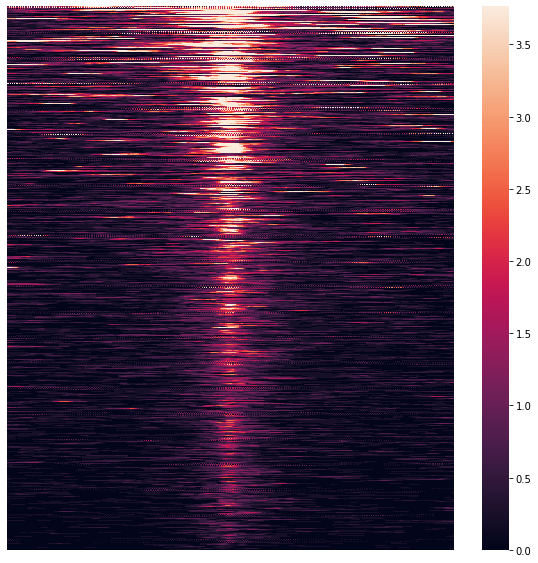

In [116]:
key = 'AST'
plt.subplots(figsize=(10,10))
ax = sns.heatmap(mat_dict[key], xticklabels=False, yticklabels=False, robust=True, vmax=maximum)

In [134]:
sampleorder = "PER MGL AST PVM OPC MOL PIR NP CGE MGE L2-3a L2-3b L4_IT L5_ET L5-6_ITa L5-6_ITb L6_CT DBL1 DBL2".split()

In [135]:
len(sampleorder)

19

In [136]:
len(mat_dict.keys())

19

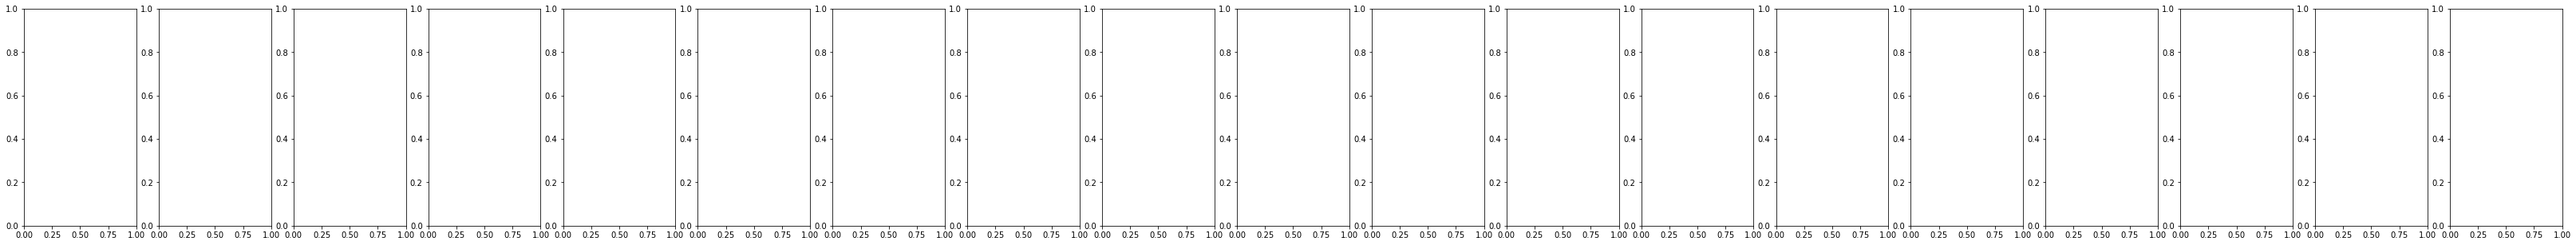

In [139]:
f,ax = plt.subplots(1,len(sampleorder))
f.set_figheight(5)
f.set_figwidth(len(sampleorder)*3)

In [140]:
for key in sampleorder:
    g = sns.heatmap(mat_dict[key], cmap="viridis", cbar=False, ax=ax[sampleorder.index(key)], vmax=maximum, xticklabels=False, yticklabels=False)

In [141]:
from IPython.display import Audio
sound_file = '/ddn1/vol1/staging/leuven/stg_00002/lcb/fderop/data/00000000_scripts/beep_silent.wav'
Audio(sound_file, autoplay=True)

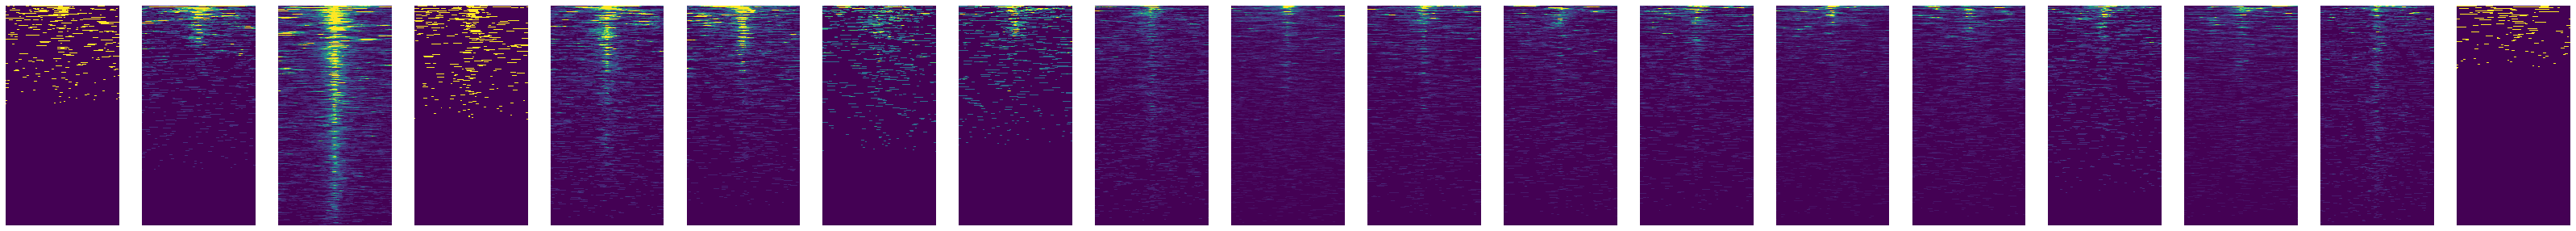

In [142]:
f

In [149]:
save_object(f, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_f.pkl')
save_object(ax, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_ax.pkl')

# Automated script with bigger binsize and only top n
To speed things up (by a lot). This code needs to be run! You can change visualisation parameters down below.

In [9]:
bed_dict.keys()

dict_keys(['L6IT_Car3', 'PIR', 'OPC', 'MGE_Sst', 'MGL', 'L5ET', 'L4IT', 'L2-3', 'END', 'MGE_Pvalb', 'AST', 'CGE_Lamp5', 'L6CT', 'NP', 'L5-6IT', 'MOL', 'UNK', 'CGE_Vip', 'L6b'])

In [10]:
bw_dict.keys()

dict_keys(['OPC', 'MOL', 'END', 'L4IT', 'AST', 'CGE_Vip', 'UNK', 'L6b', 'NP', 'L6IT_Car3', 'L2-3', 'L5ET', 'MGE_Pvalb', 'L5-6IT', 'PIR', 'CGE_Lamp5', 'L6CT', 'MGE_Sst', 'MGL'])

In [11]:
sampleorder = [
'MGL',
'AST',
'MOL',
'OPC',
'END',
'PIR',
'CGE_Lamp5',
'CGE_Vip',
'MGE_Pvalb',
'MGE_Sst',
'L2-3',
'L4IT',
'L5ET',
'NP',
'L5-6IT',
'L6CT',
'L6b',
'L6IT_Car3',
]

In [12]:
bed_dict

{'L6IT_Car3': 'DAR_beds_finalannotation_finetuned_reduced/L6IT_Car3_DARS.bed',
 'PIR': 'DAR_beds_finalannotation_finetuned_reduced/PIR_DARS.bed',
 'OPC': 'DAR_beds_finalannotation_finetuned_reduced/OPC_DARS.bed',
 'MGE_Sst': 'DAR_beds_finalannotation_finetuned_reduced/MGE_Sst_DARS.bed',
 'MGL': 'DAR_beds_finalannotation_finetuned_reduced/MGL_DARS.bed',
 'L5ET': 'DAR_beds_finalannotation_finetuned_reduced/L5ET_DARS.bed',
 'L4IT': 'DAR_beds_finalannotation_finetuned_reduced/L4IT_DARS.bed',
 'L2-3': 'DAR_beds_finalannotation_finetuned_reduced/L2-3_DARS.bed',
 'END': 'DAR_beds_finalannotation_finetuned_reduced/END_DARS.bed',
 'MGE_Pvalb': 'DAR_beds_finalannotation_finetuned_reduced/MGE_Pvalb_DARS.bed',
 'AST': 'DAR_beds_finalannotation_finetuned_reduced/AST_DARS.bed',
 'CGE_Lamp5': 'DAR_beds_finalannotation_finetuned_reduced/CGE_Lamp5_DARS.bed',
 'L6CT': 'DAR_beds_finalannotation_finetuned_reduced/L6CT_DARS.bed',
 'NP': 'DAR_beds_finalannotation_finetuned_reduced/NP_DARS.bed',
 'L5-6IT': '

In [13]:
bw_dict

{'OPC': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/OPC.bw',
 'MOL': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/MOL.bw',
 'END': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/END.bw',
 'L4IT': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/L4IT.bw',
 'AST': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/AST.bw',
 'CGE_Vip': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/CGE_Vip.bw',
 'UNK': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/UNK.bw',
 'L6b': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_finetuned_reduced/L6b.bw',
 'NP': 'pycistopic_consensus/pseudobulk_bigwig_afterconsensusregions_finalannotation_f

In [14]:
max_dict = {}
interval_downstream = 1000
interval_upstream = 1000
binsize = 100
n_top = 1000

MGL
6.585671048331237
1.701047283883769


/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


AST
4.077599639272671
1.3227338790893555
MOL
6.790816091442076
1.4472351837158204
OPC
4.497250356650336
1.3888771636486115
END
4.296466409349423
1.5546015202999115
PIR
4.378248982882499
1.7705430115114973
CGE_Lamp5
3.008721363949776
1.5150220191240311
CGE_Vip
2.709926002454758
1.3859223571855177
MGE_Pvalb
2.681380211898256
1.3227338790893555
MGE_Sst
2.633809383630736
1.3227338790893555
L2-3
2.666508257985105
1.3227338790893555
L4IT
3.300021663713435
1.374430145674944
L5ET
3.1092050315380093
1.3227338790893555
NP
5.263634586334229
1.9952847385406494
L5-6IT
3.143958272957799
1.34362084515096
L6CT
3.862786651062961
1.6418434430480082
L6IT_Car3
3.49997789573668
1.431771980559826
L6b
3.666611976885789
1.5586452293395996


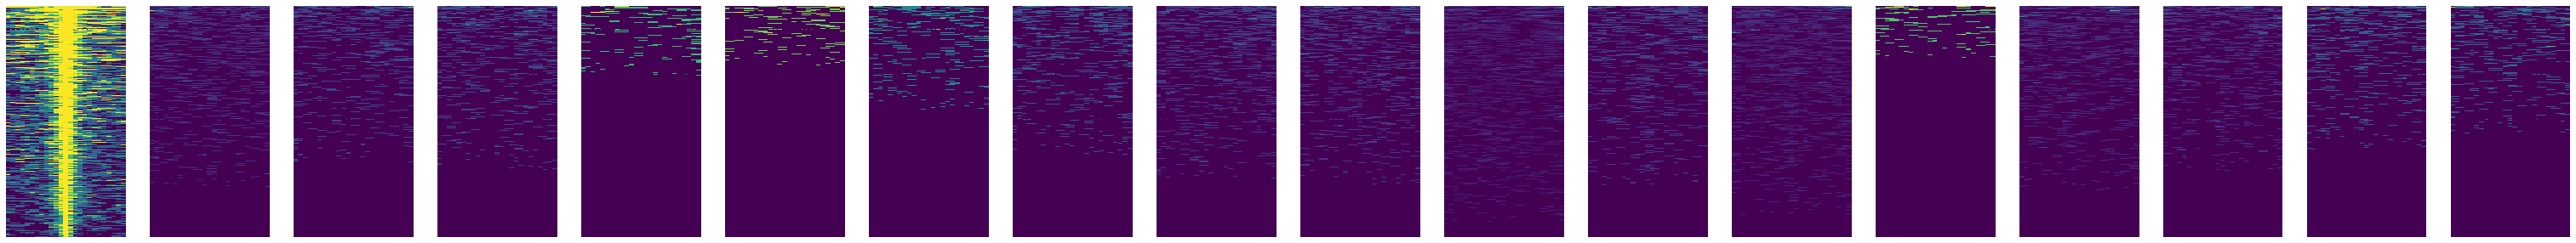

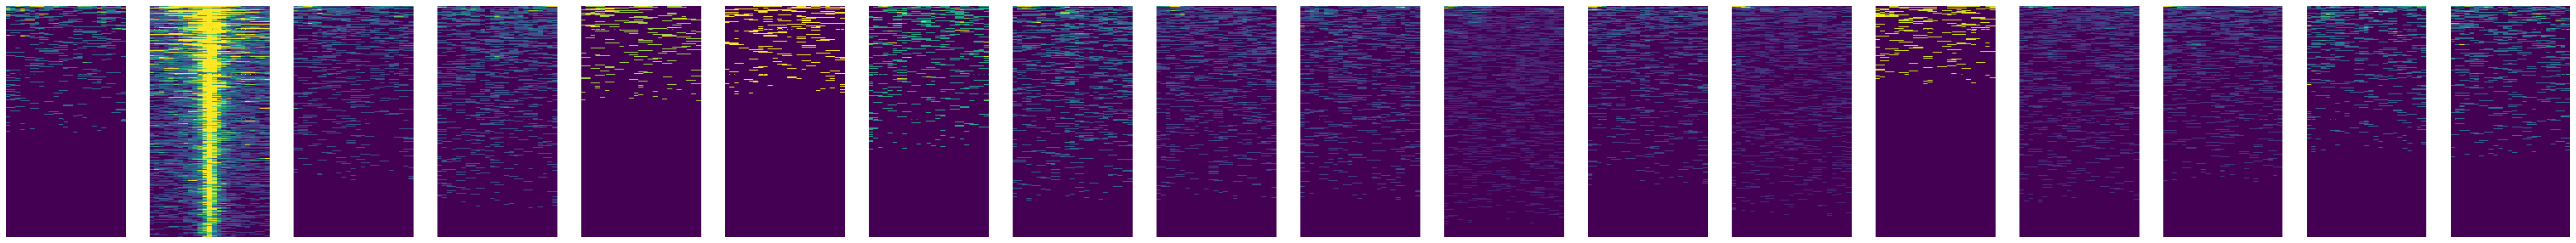

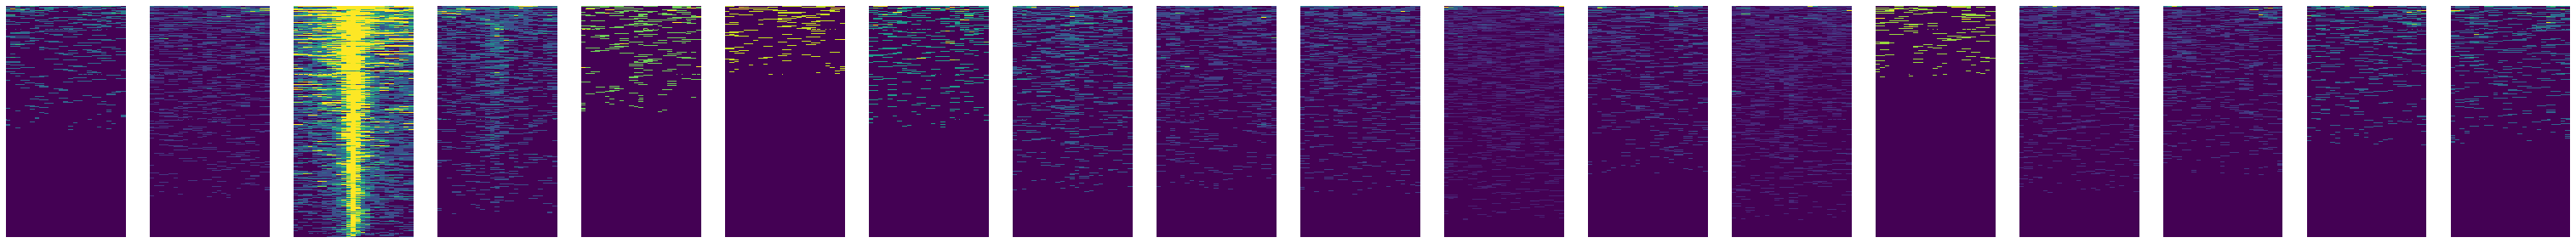

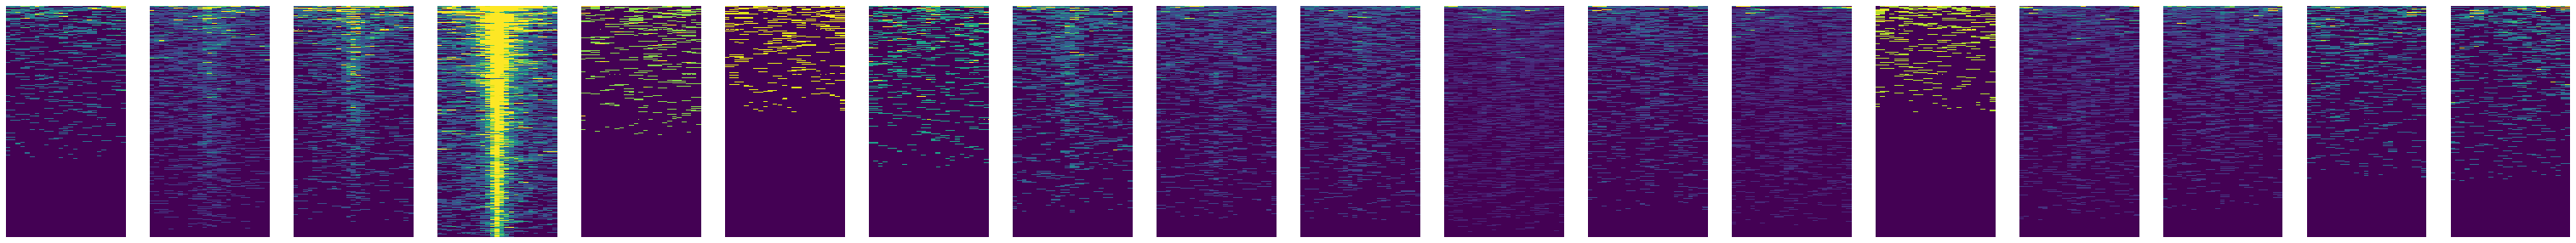

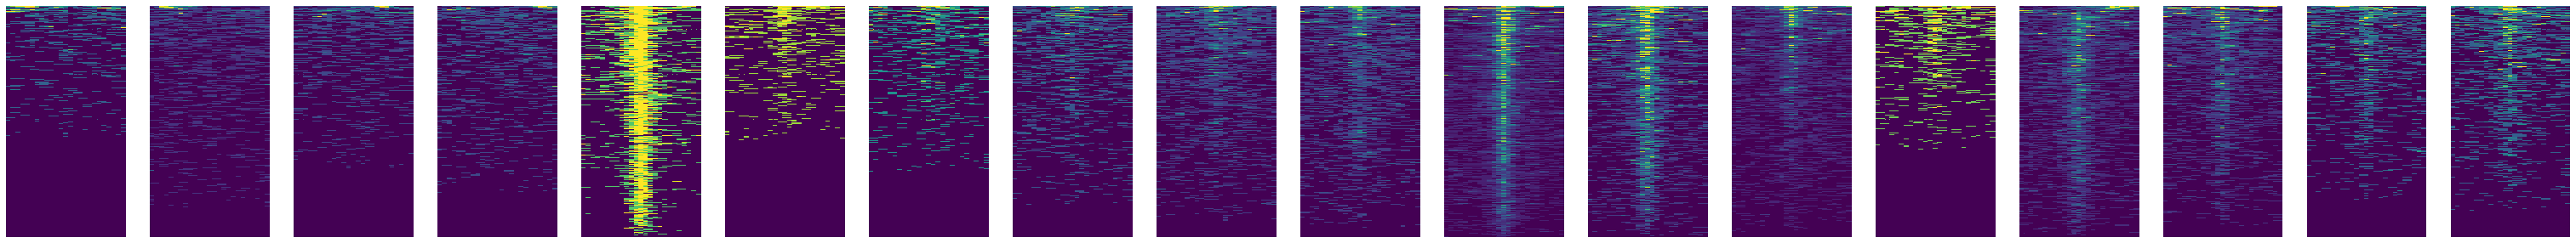

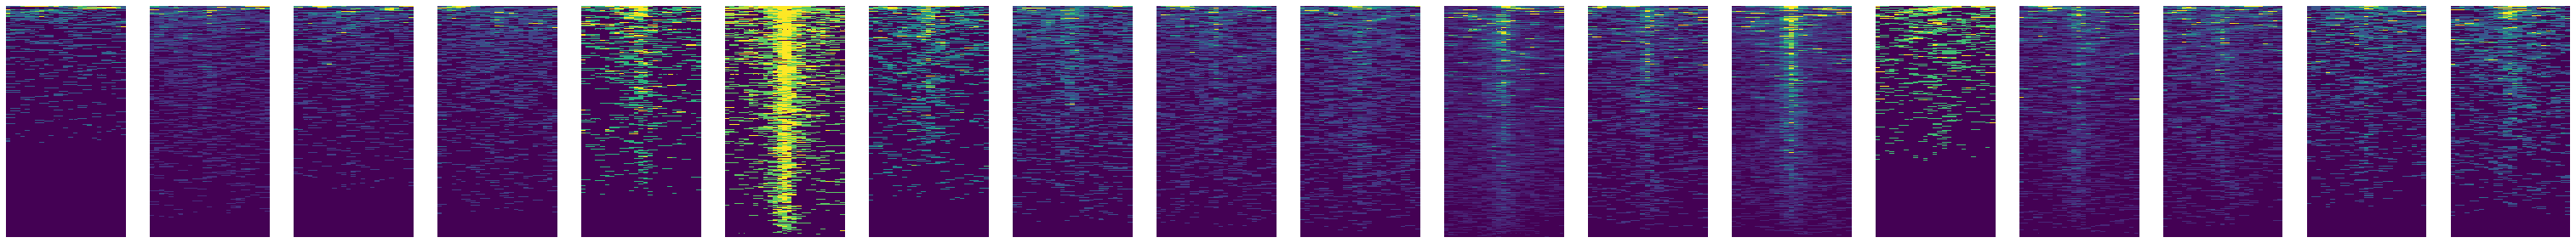

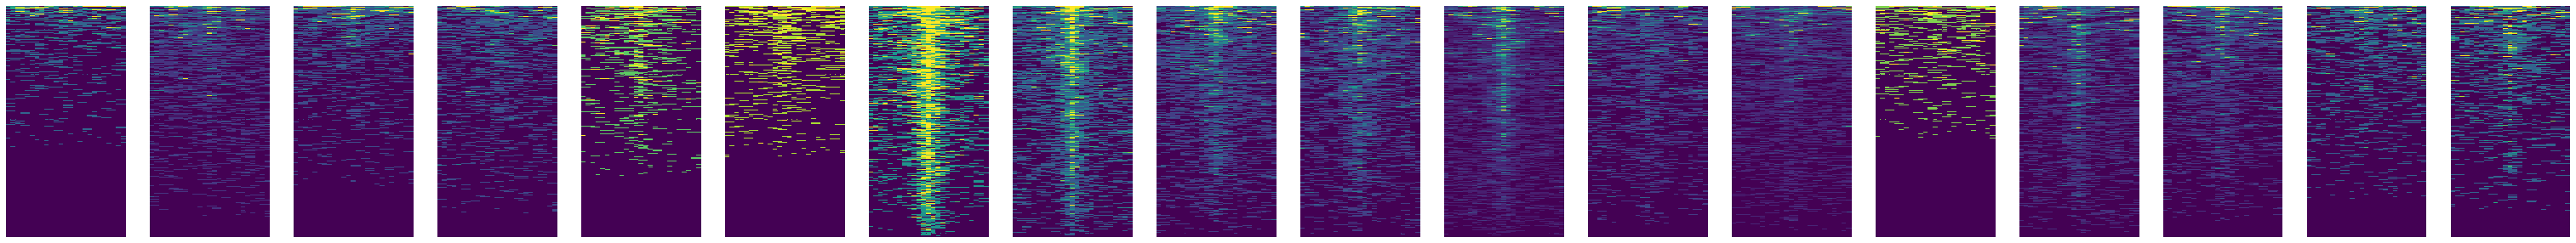

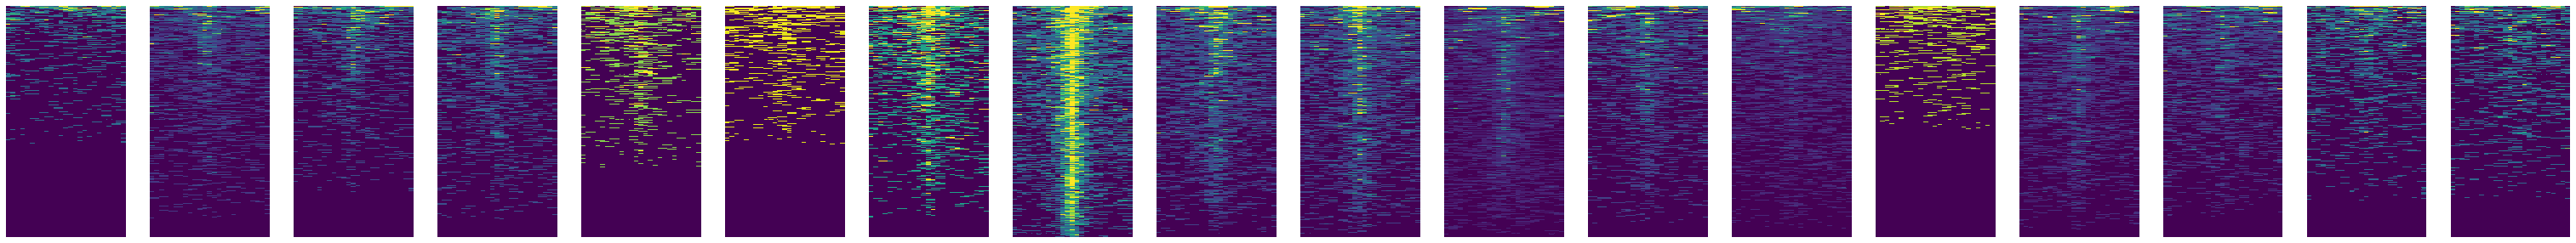

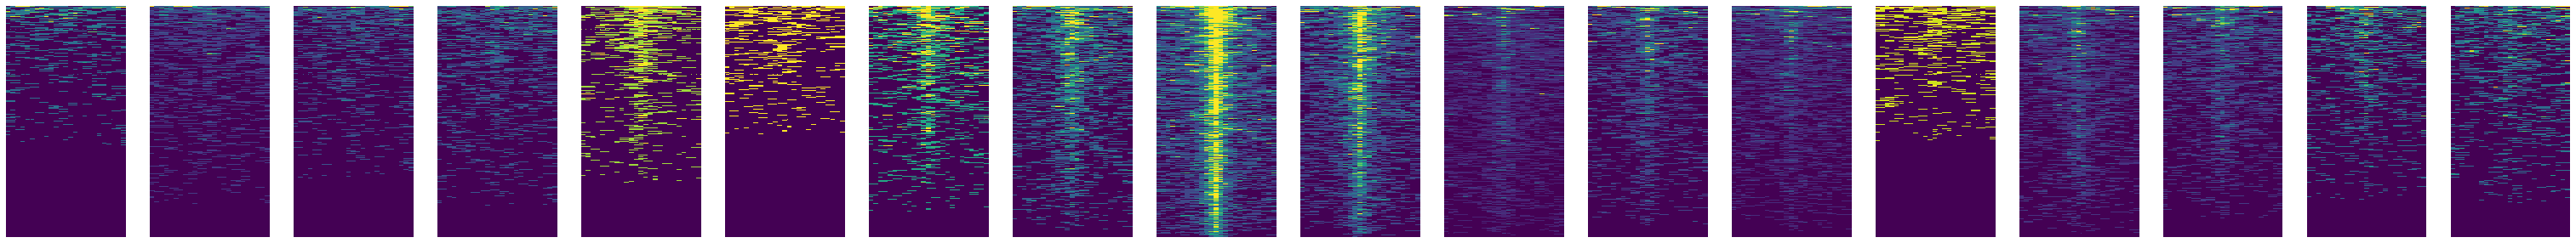

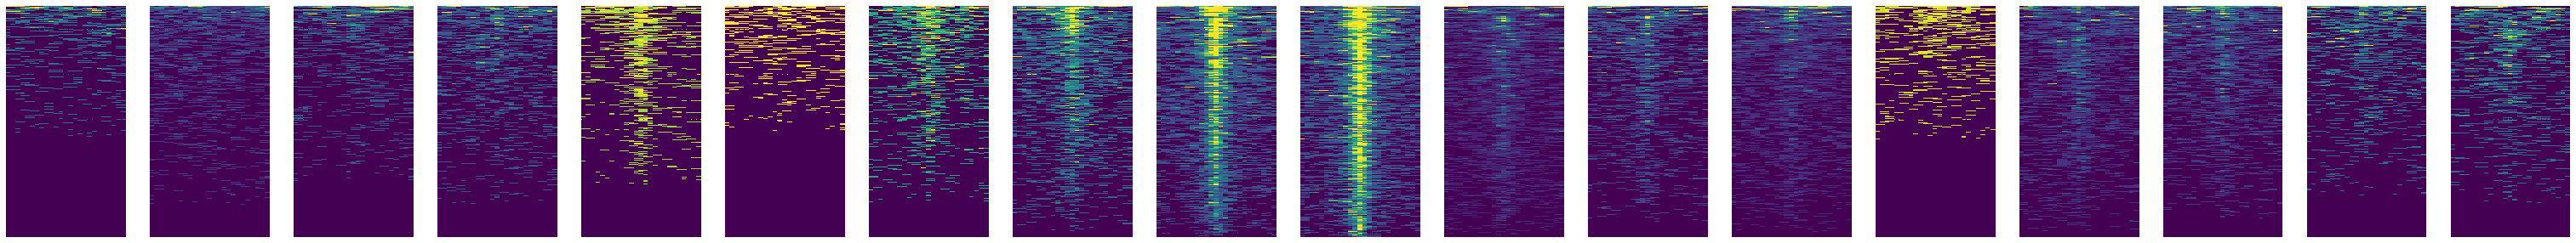

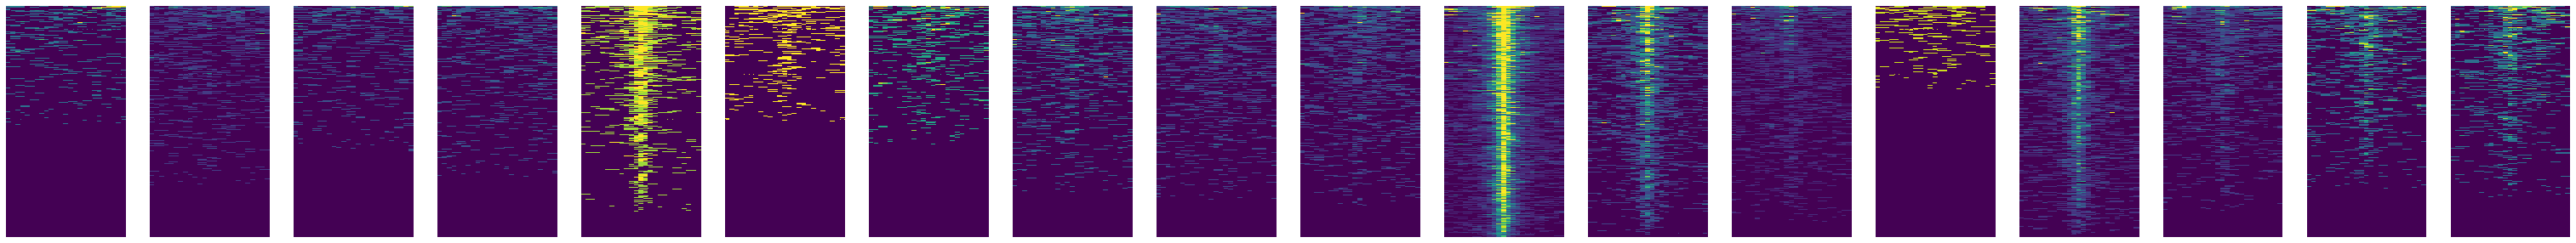

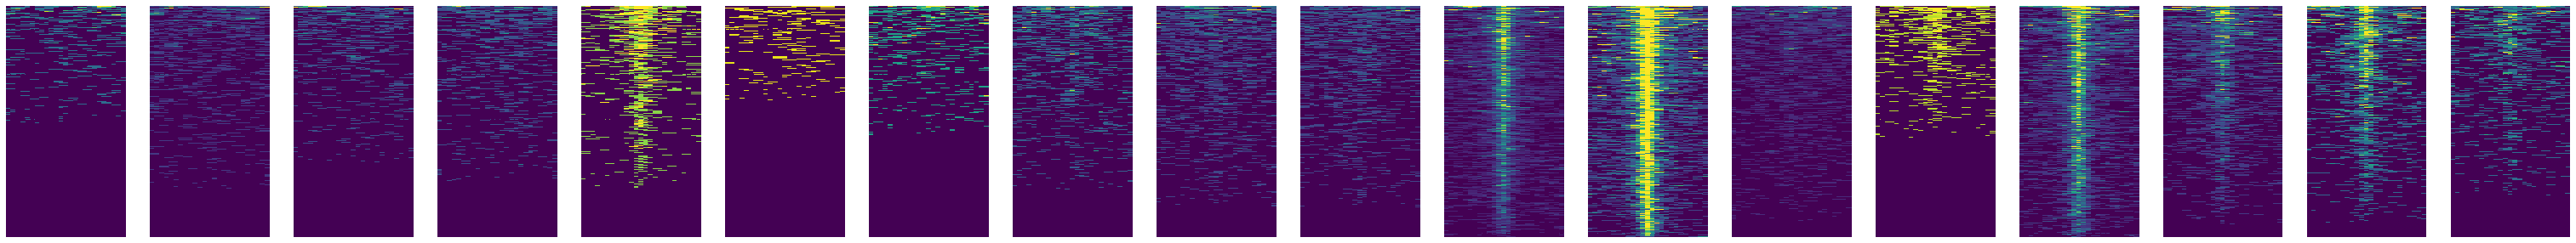

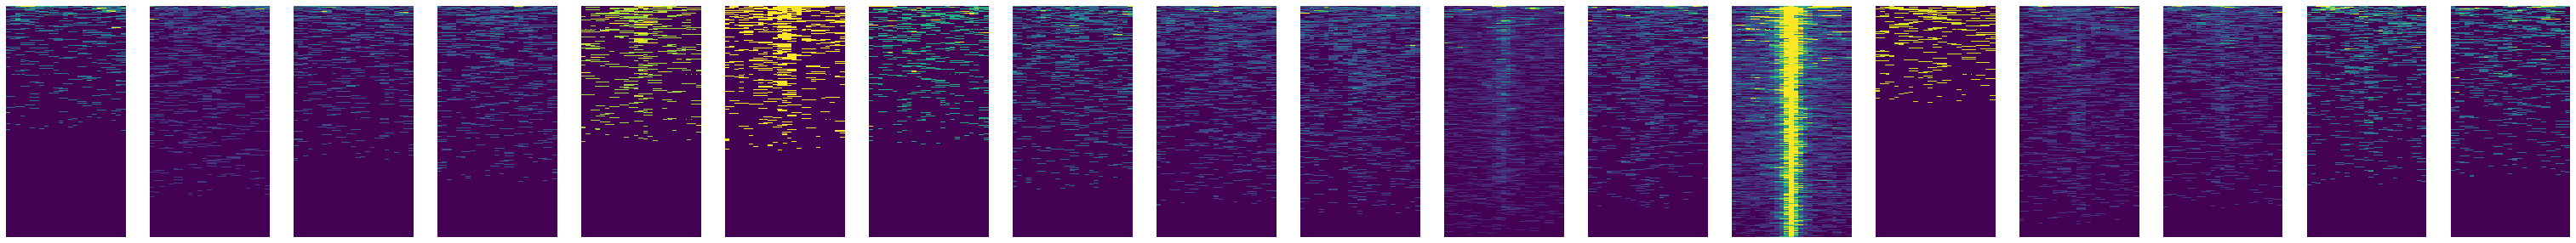

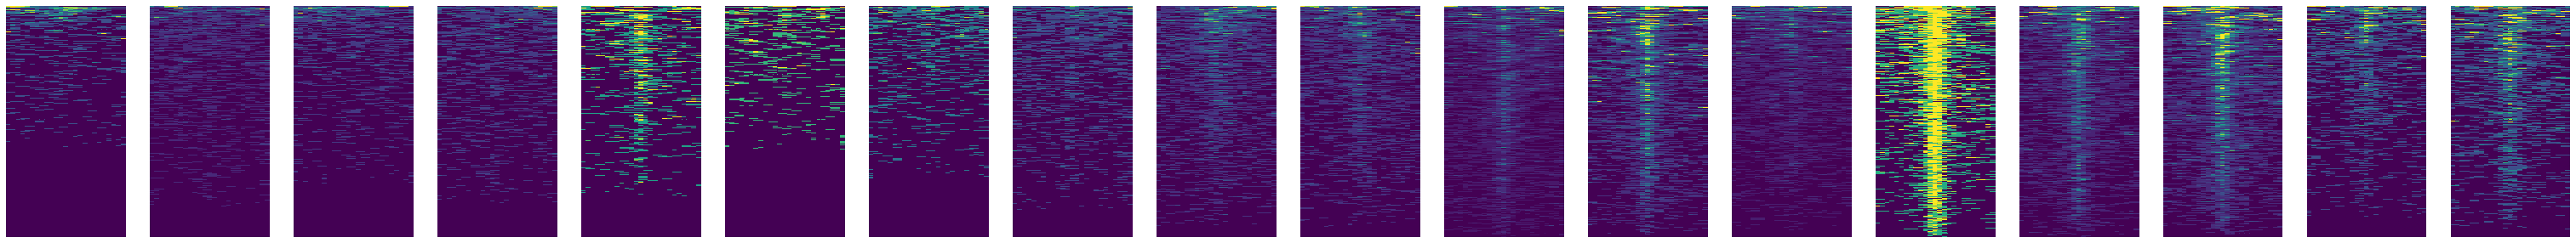

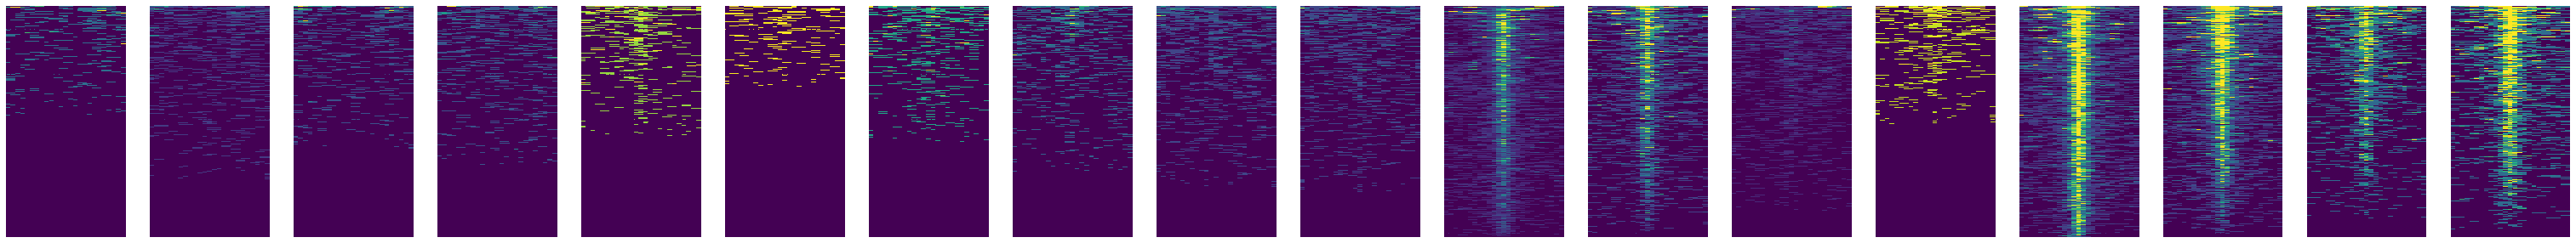

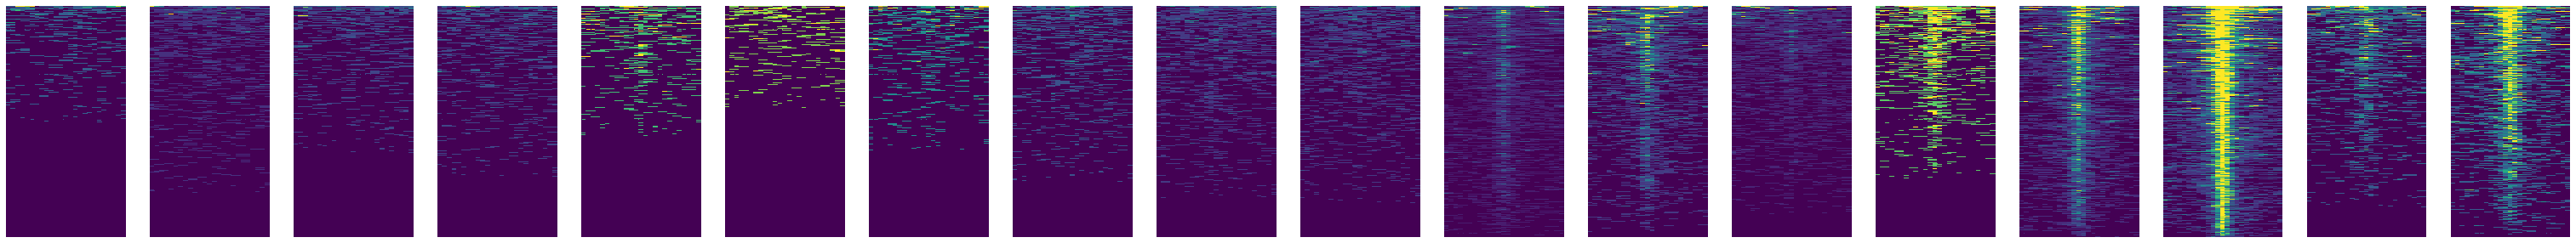

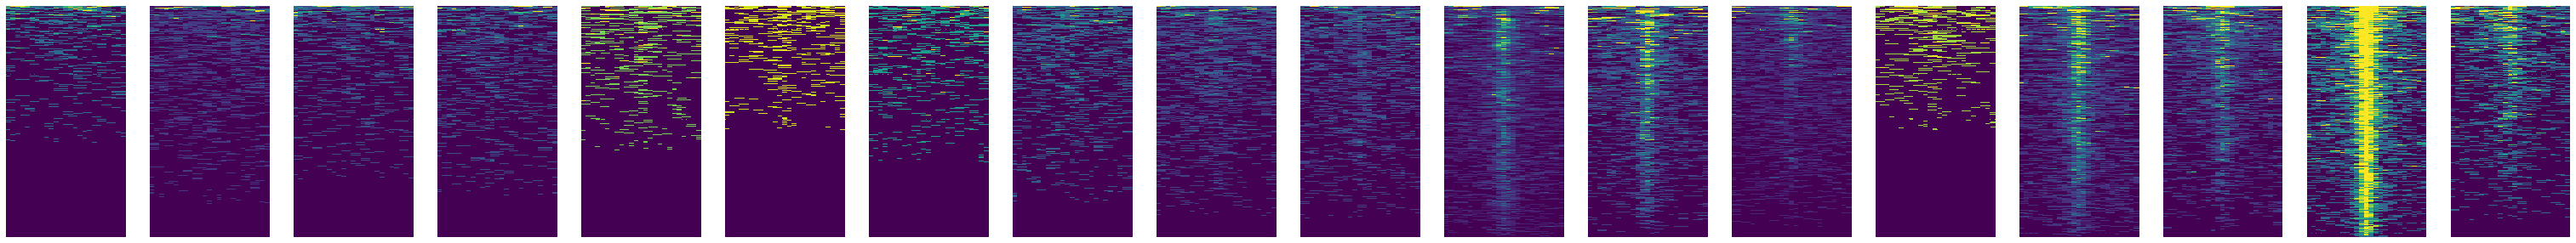

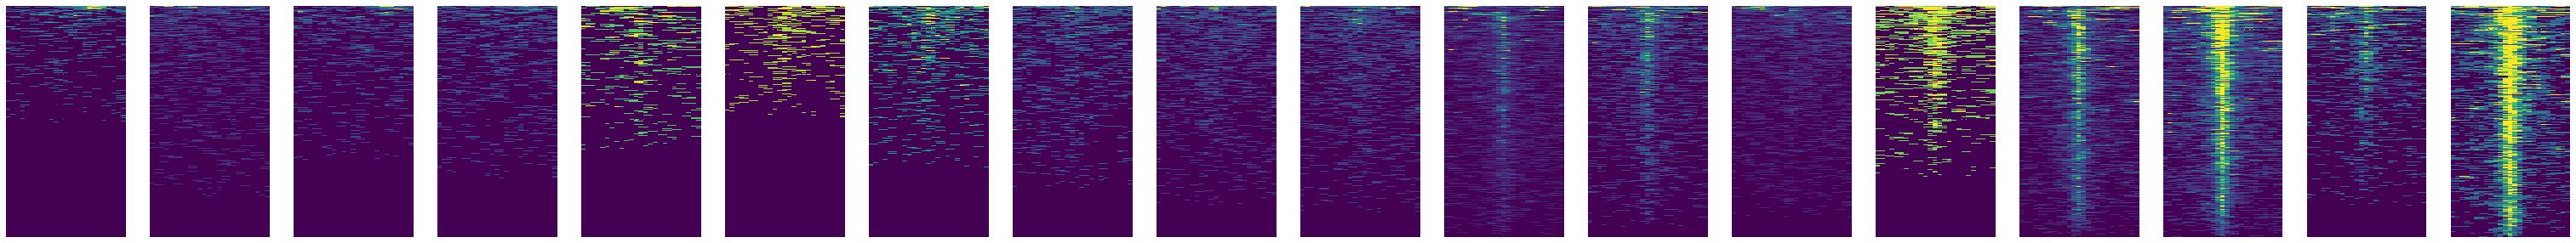

In [15]:
max_dict = {}
interval_downstream = 1000
interval_upstream = 1000
binsize = 100
n_top = 1000

for sample in sampleorder:
    print(sample)
    df_bed = pd.read_csv(bed_dict[sample], sep='\t', header=None)
    df_bed.columns = ['chr', 'start', 'stop', 'name', 'score']
    df_bed.set_index('name', inplace=True)
    df_bed.index.name = None
    df_bed = df_bed[0:n_top]

    def read_bw_values(bed_part, bw_dict, sample):
        bw = pyBigWig.open(bw_dict[sample])
        colnames = np.append(np.arange(-1250,0), np.arange(0,1250)) # colnames are a range over the interval that we look at
        df = pd.DataFrame(columns=colnames)
        for line in bed_part.iterrows():
            vals = bw.values(line[1][0], int(line[1][1])-interval_downstream, int(line[1][2])+interval_upstream)
            df.loc[line[0]] = vals

        return df

    #Choose number of cores and split input array.
    cores = 32
    torun = np.array_split(df_bed, cores, axis=0)
    iterable = zip(torun, repeat(bw_dict), repeat(sample))

    #Calculate
    pool = Pool(processes=cores)
    results = pool.starmap(read_bw_values, iterable)
    pool.close()
    pool.join()
    df = pd.concat(results)
    df_binned = df.groupby(np.arange(len(df.columns))//binsize, axis=1).mean()
    df_binned_nonan = df_binned.fillna(0)
    order = df_binned_nonan.mean(axis=1).sort_values(ascending=False) # now reorder based in maximum mean
    df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

    df_bed = df_bed.reindex(order.index)

    cores = 32

    mat_dict = {}

    for key in bw_dict.keys():
        torun = np.array_split(df_bed, cores, axis=0)
        iterable = zip(torun, repeat(bw_dict), repeat(key)) # this is the KEY difference between this and previous module. we now iterate over all keys to do all bigwigs instead of keeping all bigwigs the same

        #Calculate
        pool = Pool(processes=cores)
        results = pool.starmap(read_bw_values, iterable)
        pool.close()
        pool.join()
        df = pd.concat(results)
        df_binned = df.groupby(np.arange(len(df.columns))//binsize, axis=1).mean()
        df_binned_nonan = df_binned.fillna(0)
        order = df_binned_nonan.mean(axis=1).sort_values(ascending=False) # now reorder based in maximum mean
        df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

        mat_dict[key] = df_binned_nonan_ordered

    save_object(mat_dict, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_coveragemats_refined.pkl')

    df_merged = pd.DataFrame(columns=range(0,len(mat_dict[key].columns)))
    for key in mat_dict.keys():
        df_merged = df_merged.append(mat_dict[key], ignore_index=False)

    quantiles = df_merged.quantile(q=0.99) # for every base, calculate the quantile q value over all regions.
    maximum = quantiles.max() # then, take the maxmum value out of these 250 values.
    print(maximum) # the resulting maximum should give a cutoff that represents the 99th quantil of all values

    # alternatively, you can take a global quantile for the entire matrix (instead of per base)
    maximum = pd.np.quantile(df_merged, 0.99)
    print(maximum)
    
    max_dict[sample] = maximum
    
    f,ax = plt.subplots(1,len(sampleorder))
    f.set_figheight(5)
    f.set_figwidth(len(sampleorder)*3)

    for key in sampleorder:
        g = sns.heatmap(mat_dict[key], cmap="viridis", cbar=False, ax=ax[sampleorder.index(key)], vmax=maximum, xticklabels=False, yticklabels=False)

    # save_object(f, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(n_top)+'_f.pkl')
    # save_object(ax, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(n_top)+'_ax.pkl')

save_object(max_dict, 'heatmap_mats/DARs_binsize'+str(binsize)+'_max_dict_refined.pkl')

# Now visualise all in same subplot

In [15]:
final_sampleorder = [
'MGL',
'MOL',
'OPC',
'AST',
# 'PVM',
# 'PER',
'END',
'PIR',
'CGE_Lamp5',
'CGE_Vip',
'MGE_Pvalb',
'MGE_Sst',
'L2-3',
'L4IT',
'L5ET',
'NP',
'L5-6IT',
'L6CT',
'L6b',
'L6IT_Car3',
# 'DBL1',
# 'DBL2'
]

In [16]:
binsize = 100
filenames = glob.glob('heatmap_mats/*'+str(binsize)+'_coveragemats_refined.pkl')
samples = [item.replace('_DARs_binsize'+str(binsize)+'_coveragemats_refined.pkl', "") for item in filenames]
samples = [item.replace("heatmap_mats/", "") for item in samples]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'L2-3': 'heatmap_mats/L2-3_DARs_binsize100_coveragemats_refined.pkl',
 'MGL': 'heatmap_mats/MGL_DARs_binsize100_coveragemats_refined.pkl',
 'L5-6ITb': 'heatmap_mats/L5-6ITb_DARs_binsize100_coveragemats_refined.pkl',
 'END': 'heatmap_mats/END_DARs_binsize100_coveragemats_refined.pkl',
 'MGE_Pvalb': 'heatmap_mats/MGE_Pvalb_DARs_binsize100_coveragemats_refined.pkl',
 'L2-3a': 'heatmap_mats/L2-3a_DARs_binsize100_coveragemats_refined.pkl',
 'L2-3b': 'heatmap_mats/L2-3b_DARs_binsize100_coveragemats_refined.pkl',
 'CGE_Lamp5': 'heatmap_mats/CGE_Lamp5_DARs_binsize100_coveragemats_refined.pkl',
 'L6b': 'heatmap_mats/L6b_DARs_binsize100_coveragemats_refined.pkl',
 'AST': 'heatmap_mats/AST_DARs_binsize100_coveragemats_refined.pkl',
 'NP': 'heatmap_mats/NP_DARs_binsize100_coveragemats_refined.pkl',
 'L6CT': 'heatmap_mats/L6CT_DARs_binsize100_coveragemats_refined.pkl',
 'PIR': 'heatmap_mats/PIR_DARs_binsize100_coveragemats_refined.pkl',
 'MGE_Sst': 'heatmap_mats/MGE_Sst_DARs_binsize100_coveragemat

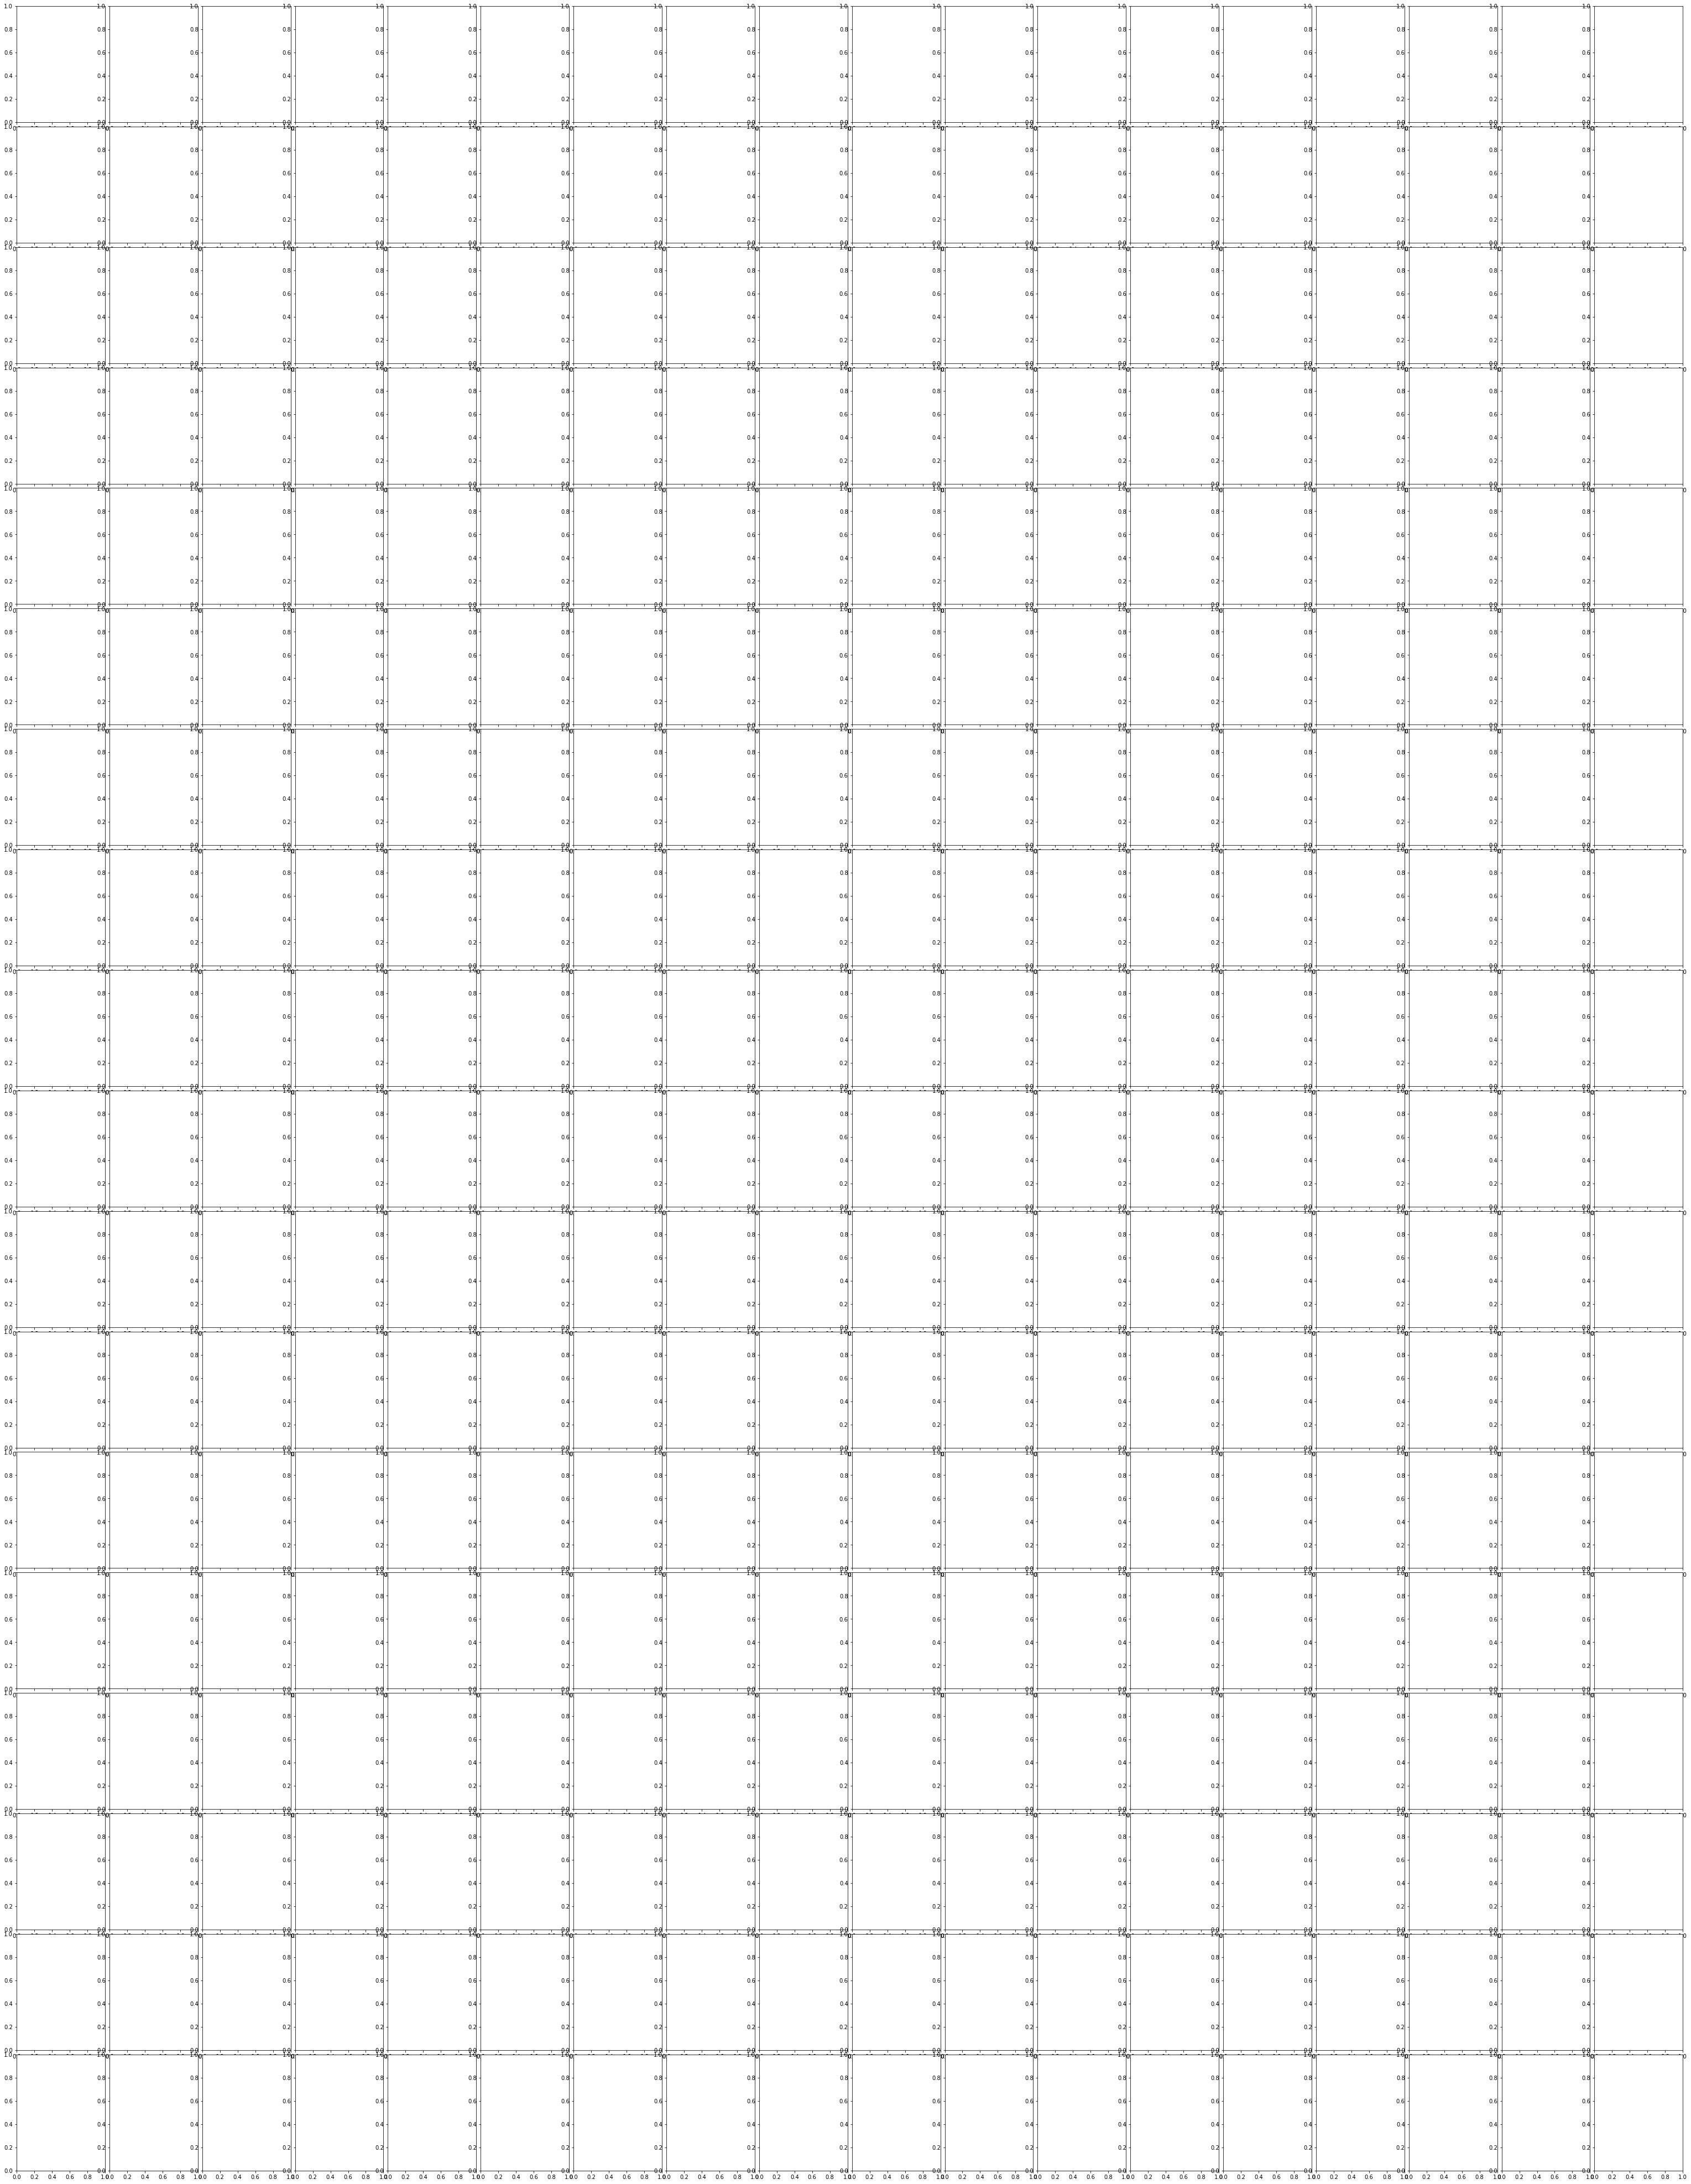

In [17]:
height = len(final_sampleorder)*4
width = len(final_sampleorder)*3
figure,axes = plt.subplots(len(final_sampleorder),len(final_sampleorder))
figure.set_figheight(height)
figure.set_figwidth(width)
figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05/(4/3))

In [18]:
top_n = 1000
with open('heatmap_mats/DARs_binsize100_max_dict_refined.pkl', 'rb') as f:
    max_dict = pickle.load(f)

for key in final_sampleorder:
    with open(coveragemats_dict[key], 'rb') as f:
        mat_dict = pickle.load(f)
    for subkey in final_sampWleorder:
        g = sns.heatmap(mat_dict[subkey][0:top_n], cmap="viridis", cbar=False, ax=axes[final_sampleorder.index(key), final_sampleorder.index(subkey)], vmax=max_dict[key], xticklabels=False, yticklabels=False)

Save the figure. A DPI of 50 is more than good enough.

In [19]:
dpi=50
n_top = 1000
figure.savefig('plts_pub/dar_heatmap_binsze'+str(binsize)+'_top'+str(n_top)+'_refined_'+str(dpi)+'dpi_reduced_reorganised.tiff', dpi=dpi)

In [20]:
final_sampleorder

['MGL',
 'MOL',
 'OPC',
 'AST',
 'END',
 'PIR',
 'CGE_Lamp5',
 'CGE_Vip',
 'MGE_Pvalb',
 'MGE_Sst',
 'L2-3',
 'L4IT',
 'L5ET',
 'NP',
 'L5-6IT',
 'L6CT',
 'L6b',
 'L6IT_Car3']